loads sat_images.nc and elevation_data.nc calcs midday values calculates cloud index and clearsky index saves everything as hdf dataframes

In [1]:
import sys
import importlib
import datetime

import numpy as np
import pandas as pd
import xarray as xr
import pvlib as pv
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters

In [ ]:
pv.atmosphere.alt2pres()
pv.spa.solar_position()
pv.atmosphere.absoluteairmass()
pv.atmosphere.relativeairmass()
pv.solarposition.pyephem_earthsun_distance()

In [3]:
this = pd.read_hdf('/home2/travis/python_code/letkf_forecasting_other_things/data/cloudiness_index.h5')

In [17]:
%matplotlib inline

In [2]:
#sys.path.append('/home/travis/python_code/letkf_forecasting/')
import letkf_forecasting.letkf_forecasting as lf
import letkf_forecasting.prepare_sat_data as prep

In [12]:
importlib.reload(prep)

<module 'letkf_forecasting.prepare_sat_data' from '/home2/travis/python_code/letkf_forecasting/letkf_forecasting/prepare_sat_data.py'>

In [3]:
sat_data = xr.open_dataset('/a2/uaren/goes_images/crop/sat_images.nc')

In [4]:
elevation_data = xr.open_dataset(
    '/home/travis/data/data/elevation_data.nc')

In [5]:
tus = pv.location.Location(32.2, -111, 'US/Arizona', 700, 'Tucson')

In [6]:
midday_sat = prep.midday(sat_data, tus, 60)

In [10]:
midday_sat.to_netcdf('midday_interp_sat.nc')

In [11]:
midday_sat = xr.open_dataset('./midday_interp_sat.nc')

In [7]:
this = midday_sat.data.values
shape = this.shape
these_times = pd.to_datetime(
    midday_sat.time).tz_localize('UTC').tz_convert('MST')
midday_sat_dataframe = pd.DataFrame(this.reshape(shape[0], shape[1]*shape[2]), index=these_times)

In [13]:
midday_sat_dataframe.to_hdf('./data/pixel.h5', 'pixel')

In [15]:
domain_shape = shape[1:]

In [14]:
np.save('./data/domain_shape', domain_shape)

In [11]:
elevation = elevation_data.elevation.values.ravel()
lats = midday_sat.lat.values.ravel()
lons = midday_sat.lon.values.ravel()
x = midday_sat.x.values.ravel()
y = midday_sat.y.values.ravel()

In [15]:
np.save('./data/elevation', elevation)
np.save('./data/lats', lats)
np.save('./data/lons', lons)
np.save('./data/x', x)
np.save('./data/y', y)

In [16]:
pixel = pd.read_hdf('./data/pixel.h5')
pixel.index = pixel.index.tz_convert('MST')
domain_shape = np.load('./data/domain_shape.npy')
elevation = np.load('./data/elevation.npy')
x = np.load('./data/x.npy')
y = np.load('./data/y.npy')
lats = np.load('./data/lats.npy')
lons = np.load('./data/lons.npy')

In [9]:
pixel = midday_sat_dataframe

In [12]:
importlib.reload(prep)
low, up, cloudiness_index = prep.get_cloudiness_index(pixel, lats, lons, elevation)

In [21]:
np.save('./data/low', low)
np.save('./data/up', up)
cloudiness_index.to_hdf(
    './data/cloudiness_index.h5', 'cloudiness_index')

In [ ]:
low = np.load('/home2/travis/data/satellite_data/low.npy')
up = np.load('/home2/travis/data/satellite_data/up.npy')

In [8]:
domain_shape = np.load('/home2/travis/data/satellite_data/domain_shape.npy')

In [11]:
131044*10

1310440

In [10]:
362*362

131044

In [9]:
domain_shape

array([362, 362])

In [6]:
low.shape

(33, 131044)

In [5]:
up.shape

(131044,)

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """Entry point for launching an IPython kernel.
/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,1,'High')

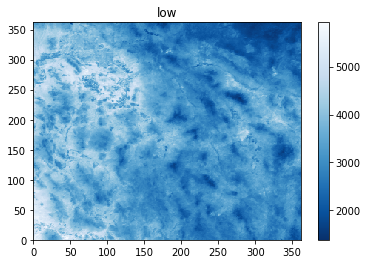

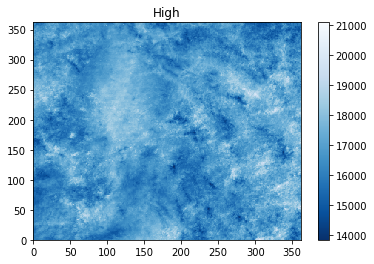

In [18]:
this_image = low.reshape(domain_shape).copy()
plt.figure()
im = plt.pcolormesh(
    this_image,
    cmap='Blues_r',
    vmin=None, vmax=None)
plt.colorbar(im)
plt.title('low')


this_image = up.reshape(domain_shape).copy()
plt.figure()
im = plt.pcolormesh(
    this_image,
    cmap='Blues_r',
    vmin=None, vmax=None)
plt.colorbar(im)
plt.title('High')

/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/home/travis/miniconda3/envs/py36letkf/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


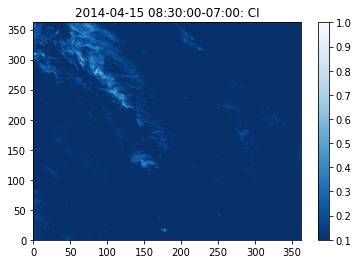

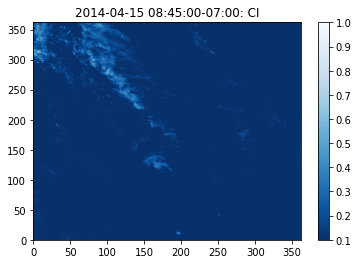

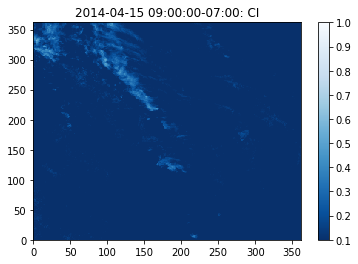

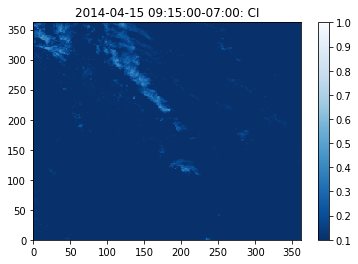

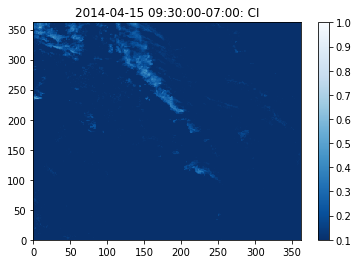

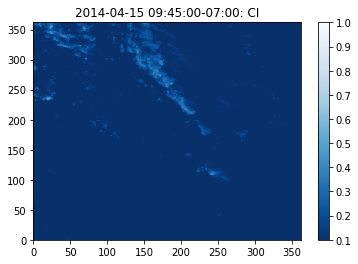

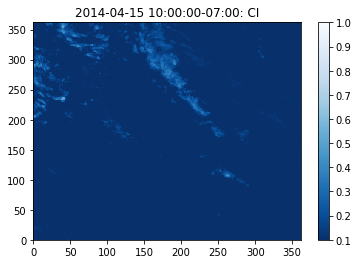

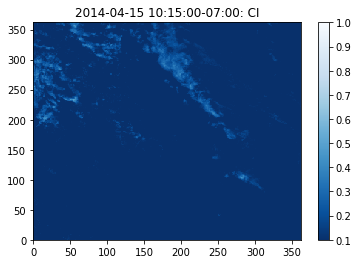

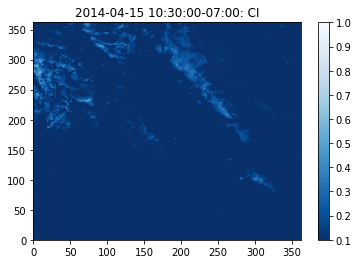

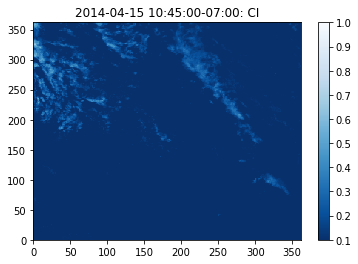

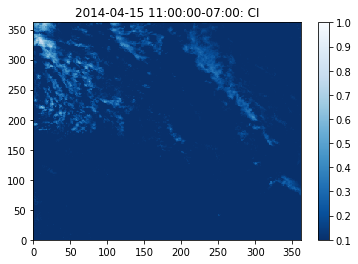

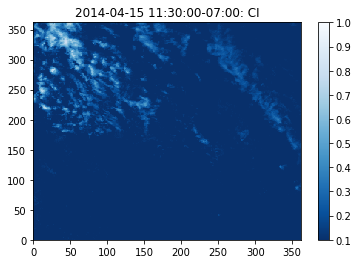

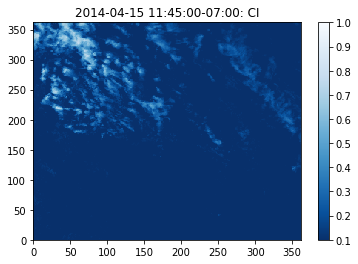

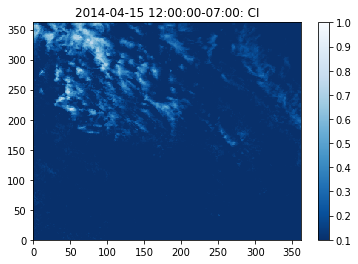

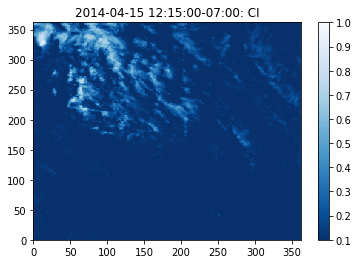

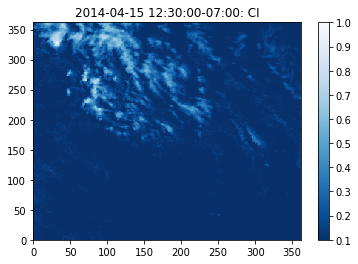

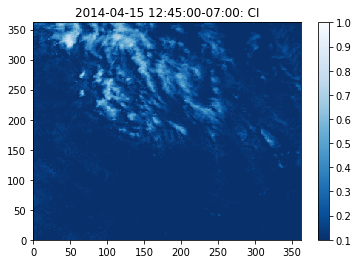

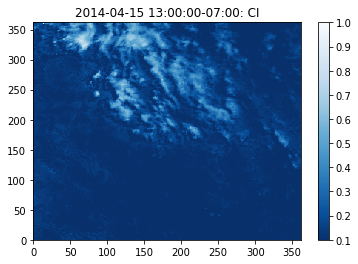

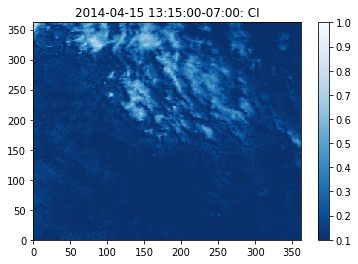

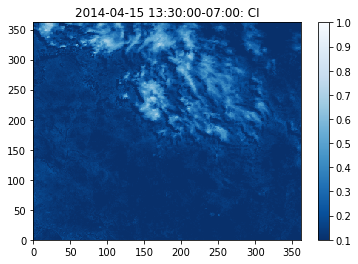

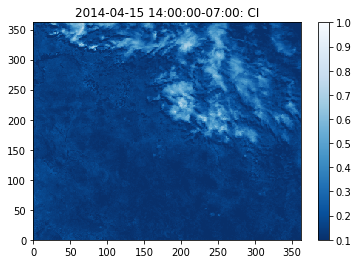

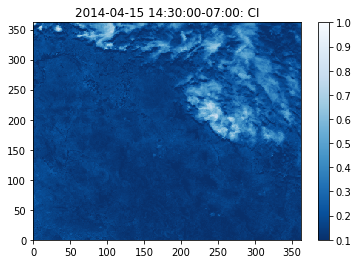

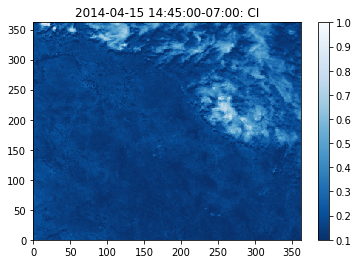

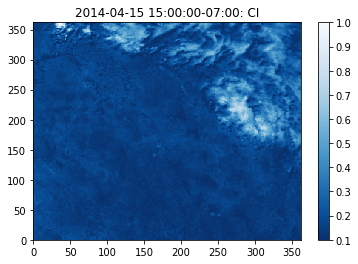

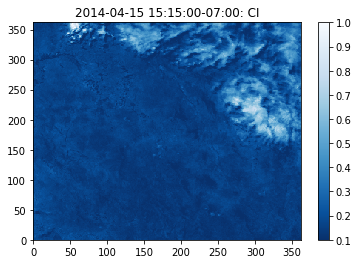

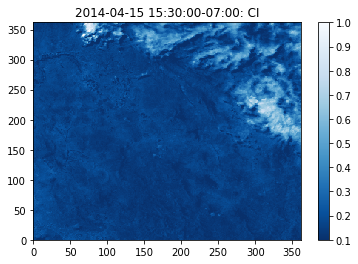

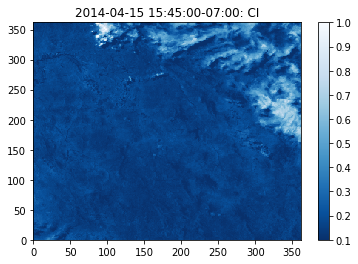

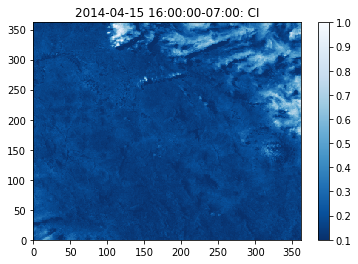

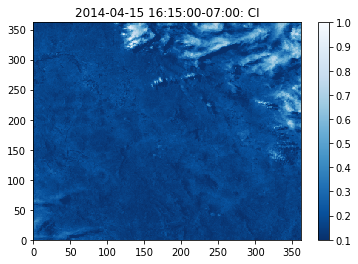

In [20]:
nc = 11
bounds = np.linspace(0, 1, nc)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

date_range = pd.date_range(
    '2014-04-15 10:00:00', freq='15 min', periods=10).tz_localize('MST')
for this_time in cloudiness_index.loc['2014-04-15'].index:
    # this_time = pd.Timestamp('2014-04-15 12:45:00').tz_localize('MST')
    this_image = cloudiness_index.loc[this_time].reshape(domain_shape).copy()
    plt.figure()
    im = plt.pcolormesh(
        this_image,
        cmap='Blues_r',
        vmin=0.1, vmax=1)
    plt.colorbar(im)
    plt.title(str(this_time) + ': CI')
    
    plt.figure()
    im = plt.pcolormesh(
        this_image,
        cmap='Blues_r',
        norm=norm)
    plt.colorbar(im)
    plt.title(str(this_time) + ': CI')

In [17]:
this_time = pd.Timestamp('2014-04-14 12:45:00').tz_localize('MST')
plt.figure()
this_image = cloudiness_index.loc[this_time].reshape(domain_shape).copy()
print(this_image.max() - this_image.min())
im = plt.pcolormesh(
    this_image,
    cmap='Blues',
    vmin=0, vmax=1)
plt.colorbar(im)

NameError: name 'cloudiness_index' is not defined

In [ ]:
cloudiness_index2 = pd.read_hdf('./data/cloudiness_index.h5')

In [ ]:
cloudiness_index

In [ ]:
cloudiness_index.index

In [ ]:
cloudiness_index.index[0]

In [ ]:
cloudiness_index.index = cloudiness_index.index.tz_convert('MST')

In [ ]:
cloudiness_index.index[0]

In [ ]:
cloudiness_index.shape

In [ ]:
cloudiness_index.to_hdf('./data/cloudiness_index.h5', 'cloudiness_index')

In [ ]:
low = np.load('./data/low.npy')
up = np.load('./data/up.npy')
cloudiness_index = pd.read_hdf('./data/cloudiness_index.h5')

In [ ]:
importlib.reload(prep)
clearsky = prep.get_clearsky(pixel.index, elevation, lats, lons)

In [ ]:
clearsky.to_hdf('./data/clearsky.h5', 'clearsky')

In [ ]:
clearsky.shape

In [ ]:
this_time = pd.Timestamp('2014-04-15 12:45:00').tz_localize('MST')
CI = cloudiness_index.ix[this_time].reshape(domain_shape).copy()
ktm = 2.36*CI**5 - 6.2*CI**4 + 6.22*CI**3 - 2.63*CI**2 - 0.58*CI + 1
Ghcnew = clearsky.ix[this_time].reshape(domain_shape).copy()
GHI = ktm*Ghcnew*(0.0001*ktm*Ghcnew + 0.9)

In [ ]:
this_time = pd.Timestamp('2014-04-14 12:45:00').tz_localize('MST')
CI_c = cloudiness_index.ix[this_time].reshape(domain_shape).copy()
ktm_c = 2.36*CI_c**5 - 6.2*CI_c**4 + 6.22*CI_c**3 - 2.63*CI_c**2 - 0.58*CI_c + 1
Ghcnew_c = clearsky.ix[this_time].reshape(domain_shape).copy()
GHI_c = ktm_c*Ghcnew_c*(0.0001*ktm_c*Ghcnew_c + 0.9)

In [ ]:
plt.figure()
this_image = GHI/GHI_c
print(this_image.max() - this_image.min())
im = plt.pcolormesh(
    this_image,
    cmap='Blues',
    vmin=0, vmax=1)
plt.colorbar(im)

plt.figure()
this_image = GHI/Ghcnew
print(this_image.max() - this_image.min())
im = plt.pcolormesh(
    this_image,
    cmap='Blues',
    vmin=0, vmax=1)
plt.colorbar(im)